#     **Cloud Masking in Satellite Images: A Comparison Between U-Net and K-Means Clustering**
**De Luca Alessio**
*Mat. 919790*

## **Cella da usare su Colab**

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sorour_38cloud_cloud_segmentation_in_satellite_images_path = kagglehub.dataset_download('sorour/38cloud-cloud-segmentation-in-satellite-images')

print('Data source import complete.')


Data source import complete.


## **Librerie**

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from skimage import exposure
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd


## **Dataset**

In [ ]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, max_images=None, pytorch=True):
        super().__init__()

        # Prendo solo le immagini dalla cartella di training
        all_files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]

        # Se max_images è specificato, limito il dataset (max images serve per testare velocemente il lavoro)
        if max_images:
            self.files = random.sample(all_files, min(max_images, len(all_files)))
        else:
            self.files = all_files

        self.pytorch = pytorch

    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        files = {
            'red': r_file,
            'green': g_dir / r_file.name.replace('red', 'green'),
            'blue': b_dir / r_file.name.replace('red', 'blue'),
            'nir': nir_dir / r_file.name.replace('red', 'nir'),
            'gt': gt_dir / r_file.name.replace('red', 'gt')
        }
        return files

    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=True):
        raw_rgb = np.stack([
            np.array(Image.open(self.files[idx]['red'])),
            np.array(Image.open(self.files[idx]['green'])),
            np.array(Image.open(self.files[idx]['blue']))
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))

        # Normalizzo i valori tra 0 e 1
        return raw_rgb / np.iinfo(raw_rgb.dtype).max

    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        return x, y



In [ ]:
sorour_38cloud_cloud_segmentation_in_satellite_images_path


'/root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4'

In [ ]:
# base path se si usa colab:
base_path = Path('/root/.cache/kagglehub/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images/versions/4/38-Cloud_training')

#base path se si usa kaggle
# base_path = Path('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')

# Numero massimo di immagini da utilizzare
#max_images = 500  (commentato uso tutto il dataset)


dataset = CloudDataset(
    base_path / 'train_red',
    base_path / 'train_green',
    base_path / 'train_blue',
    base_path / 'train_nir',
    base_path / 'train_gt',
    #max_images=max_images
)


print(f"Numero di immagini utilizzate nel dataset: {len(dataset)}")


Numero di immagini utilizzate nel dataset: 8400


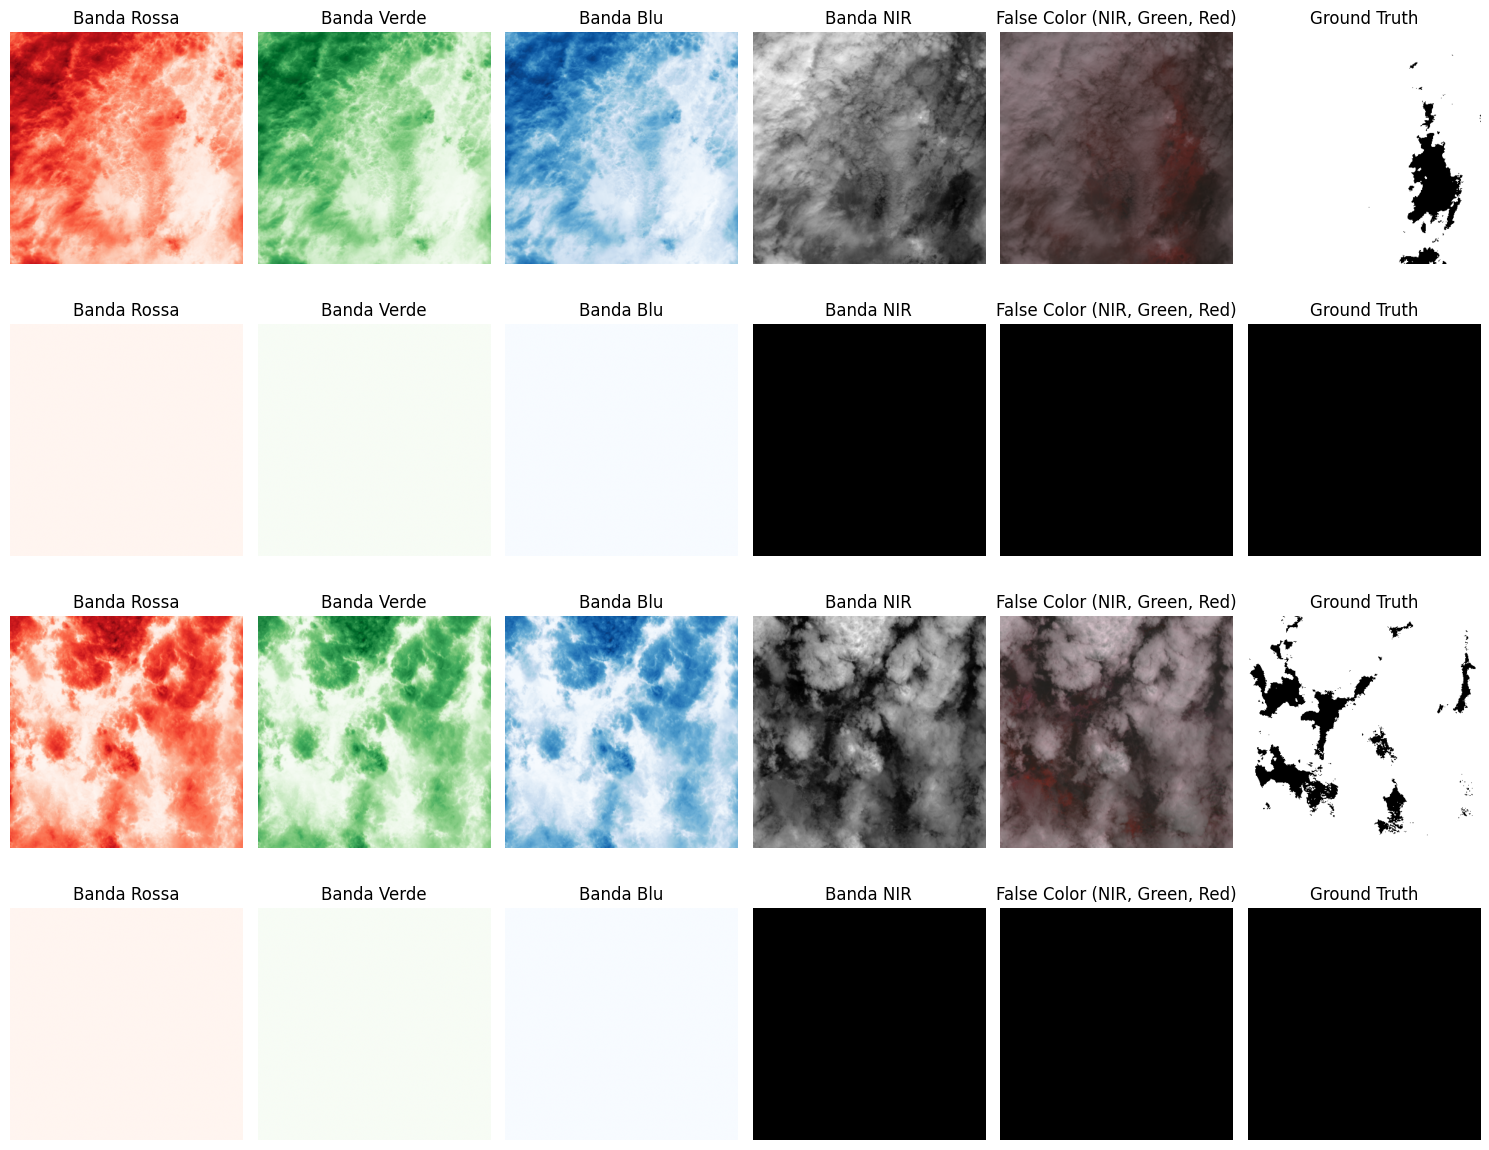

In [ ]:


def plot_samples(dataset, num_samples=4):
    """
    Mostra immagini casuali dal dataset, visualizzando le bande singole Red, Green, Blue, NIR,
    la visualizzazione False Color (NIR, Green, Red) e la Ground Truth.
    """
    indices = random.sample(range(len(dataset)), num_samples)  # Selezione casuale delle immagini

    fig, axs = plt.subplots(num_samples, 6, figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]


        img = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
        mask = mask.numpy()

        # False Color (NIR, Green, Red)
        false_color = np.stack([img[:, :, 3], img[:, :, 1], img[:, :, 0]], axis=2)


        axs[i, 0].imshow(img[:, :, 0], cmap="Reds")
        axs[i, 0].set_title("Banda Rossa")

        axs[i, 1].imshow(img[:, :, 1], cmap="Greens")
        axs[i, 1].set_title("Banda Verde")

        axs[i, 2].imshow(img[:, :, 2], cmap="Blues")
        axs[i, 2].set_title("Banda Blu")

        axs[i, 3].imshow(img[:, :, 3], cmap="gray")
        axs[i, 3].set_title("Banda NIR")

        axs[i, 4].imshow(false_color)
        axs[i, 4].set_title("False Color (NIR, Green, Red)")

        axs[i, 5].imshow(mask, cmap="gray")
        axs[i, 5].set_title("Ground Truth")

        for j in range(6):
            axs[i, j].axis("off")

    plt.tight_layout()
    plt.show()

plot_samples(dataset, num_samples=4)


In [ ]:
# split del dataset
train_size = int(0.7 * len(dataset))  # 70% per il training
val_size = int(0.2 * len(dataset))    # 20% per la validation
test_size = len(dataset) - train_size - val_size  # 10% per il test

# Suddivisione casuale
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


print(f"Train set: {len(train_dataset)} immagini")
print(f"Validation set: {len(val_dataset)} immagini")
print(f"Test set: {len(test_dataset)} immagini")


Train set: 5880 immagini
Validation set: 1680 immagini
Test set: 840 immagini


In [ ]:
batch_size = 8

#  DataLoader per i tre set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 735
Validation batches: 210
Test batches: 105


## **U-Net**

In [ ]:
# modello U-Net con backbone ResNet-101 pre-addestrato su ImageNet
model = smp.Unet(
    encoder_name="resnet101",    # Backbone ResNet-101
    encoder_weights="imagenet",  # Pesi pre-addestrati su ImageNet
    in_channels=4,               #  4 canali (Red, Green, Blue, NIR)
    classes=1,                   # maschera binaria delle nuvole
    activation=None
)

# se GPU disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Modello U-Net con ResNet-101 caricato su {device}")


In [ ]:
#  funzione di perdita
loss_fn = nn.BCEWithLogitsLoss()

# ottimizzatore Adam con weight decay per migliorare la generalizzazione
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [ ]:
THRESHOLD = 0.8  # Se la probabilità è sopra TRESHOLD%, il pixel è classificato come nuvola

def threshold_output(output):
    """
    Converte i logits in probabilità con sigmoid e binarizza il risultato.
    """
    return (torch.sigmoid(output) > THRESHOLD).float()


In [ ]:
def train_model(model, train_loader, val_loader, epochs):
    """
    Funzione per addestrare il modello U-Net con ResNet-101 con tqdm e restituzione delle loss.
    """
    model.train()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0


        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [TRAIN]", leave=True)

        for images, masks in train_iterator:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, masks.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            train_iterator.set_postfix(loss=loss.item())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validazione
        avg_val_loss = validate_model(model, val_loader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses

def validate_model(model, val_loader):

    model.eval()
    val_loss = 0.0

    val_iterator = tqdm(val_loader, desc="[VALIDATION]", leave=True)

    with torch.no_grad():
        for images, masks in val_iterator:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks.float().unsqueeze(1))
            val_loss += loss.item()
            val_iterator.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    model.train()
    return avg_val_loss


In [ ]:
EPOCHS = 10  # Numero di epoche di allenamento
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=EPOCHS)


In [ ]:
def plot_losses(train_losses, val_losses):

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_losses(train_losses, val_losses)


In [ ]:

def intersection_over_union(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0  # Caso perfetto: nessuna nuvola prevista, nessuna nella ground truth
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0  # Caso peggiore: non c'è nulla da predire, ma il modello prevede qualcosa
    else:
        intersection = torch.logical_and(pred, target).sum().float()
        union = torch.logical_or(pred, target).sum().float()
        return intersection / (union + 1e-9)

def dice_coefficient(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0  # Caso perfetto
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0  # Predizione errata quando non ci sono nuvole
    else:
        intersection = torch.sum(pred * target).float()
        fsum = torch.sum(pred).float()
        ssum = torch.sum(target).float()
        return (2 * intersection) / (fsum + ssum + 1e-9)

def precision_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fp = torch.logical_and(pred, 1 - target).sum().float()
        return tp / (tp + fp + 1e-9)

def recall_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fn = torch.logical_and(1 - pred, target).sum().float()
        return tp / (tp + fn + 1e-9)

def f1_score(pred, target):
    p = precision_score(pred, target)
    r = recall_score(pred, target)
    return (2 * p * r) / (p + r + 1e-9)

def accuracy_score(pred, target):
    """
    Calcola l'accuracy come (TP + TN) / (TP + TN + FP + FN)
    """
    pred = pred.bool()
    target = target.bool()

    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0  # Caso perfetto: nessuna nuvola prevista, nessuna nella ground truth
    else:
        tp = torch.logical_and(pred, target).sum().float()
        tn = torch.logical_and(~pred, ~target).sum().float()
        fp = torch.logical_and(pred, ~target).sum().float()
        fn = torch.logical_and(~pred, target).sum().float()
        return (tp + tn) / (tp + tn + fp + fn + 1e-9)




In [ ]:
def evaluate_unet(test_loader, model, device, threshold):
    """
    Valuta la U-Net sul test set e calcola le metriche.
    """
    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []

    model.eval()

    with torch.no_grad():
        test_iterator = tqdm(test_loader, desc="[TESTING U-NET]", leave=True)

        for images, masks in test_iterator:
            images, masks = images.to(device), masks.to(device)

            # Predizione del modello
            predicted_masks = model(images)
            predicted_masks_binary = (torch.sigmoid(predicted_masks) > threshold).float()

            for i in range(images.size(0)):  # Iteriamo sui batch
                pred_mask = predicted_masks_binary[i].squeeze()
                true_mask = masks[i].squeeze()

                iou = intersection_over_union(pred_mask, true_mask)
                dice = dice_coefficient(pred_mask, true_mask)
                precision = precision_score(pred_mask, true_mask)
                recall = recall_score(pred_mask, true_mask)
                f1 = f1_score(pred_mask, true_mask)
                accuracy = accuracy_score(pred_mask, true_mask)

                iou_scores.append(iou)
                dice_scores.append(dice)
                precision_scores.append(precision)
                recall_scores.append(recall)
                f1_scores.append(f1)
                accuracy_scores.append(accuracy)

            test_iterator.set_postfix(IoU=iou, Dice=dice)

    # medie delle metriche
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_precision = sum(precision_scores) / len(precision_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)
    mean_f1 = sum(f1_scores) / len(f1_scores)
    mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    print(f'\n✅ U-Net Evaluation Completed!')
    print(f'Mean IoU: {mean_iou:.4f}')
    print(f'Mean DICE Coefficient: {mean_dice:.4f}')
    print(f'Mean Precision: {mean_precision:.4f}')
    print(f'Mean Recall: {mean_recall:.4f}')
    print(f'Mean F1 Score: {mean_f1:.4f}')
    print(f'Mean Accuracy: {mean_accuracy:.4f}')

    return {
        "IoU": mean_iou,
        "Dice": mean_dice,
        "Precision": mean_precision,
        "Recall": mean_recall,
        "F1": mean_f1,
        "Accuracy": mean_accuracy,
    }


In [ ]:
unet_metrics = evaluate_unet(test_loader, model, device, threshold=THRESHOLD)




In [ ]:


def visualize_predictions(model, test_dataset, num_samples):

    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, mask = test_dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)

            # Predizione del modello
            output = model(img_tensor)
            output = torch.sigmoid(output).cpu().squeeze().numpy()
            pred_mask = (output > THRESHOLD).astype(np.uint8)  # binarizzo la predizione

            img = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
            mask = mask.numpy()

            axs[i, 0].imshow(img[:, :, :3])  # Mostriamo RGB
            axs[i, 0].set_title("Immagine Originale")

            axs[i, 1].imshow(pred_mask, cmap="gray")
            axs[i, 1].set_title("Maschera Predetta")

            axs[i, 2].imshow(mask, cmap="gray")
            axs[i, 2].set_title("Ground Truth")

            for j in range(3):
                axs[i, j].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_predictions(model, test_dataset, num_samples=10)


## **K-Means BASE**

In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Nasconde warning di K-Means

def apply_kmeans(img, k=2):
    """
    Applica K-Means clustering all'immagine.

    1. L'immagine viene convertita in una matrice di pixel (H*W, C).
    2. I pixel vengono normalizzati tra 0 e 1.
    3. Si applica K-Means con K=2 (nuvole/non-nuvole).
    4. Si ricostruisce l'immagine segmentata.
    """
    H, W, C = img.shape
    img_reshaped = img.reshape(-1, C)


    scaler = MinMaxScaler()
    img_reshaped = scaler.fit_transform(img_reshaped)

    # Applicazione di K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(img_reshaped)
    labels = kmeans.labels_

    clustered_img = labels.reshape(H, W)
    return clustered_img


In [ ]:
#ho introdotto questa funzione per risolvere un problema dei clusters, a volte clusterizzava bene ma invertiva le ettichette (le nuvole venivano identificate ma messe come non nuvole e viceversa per il non nuvola)
def align_clusters(pred_mask, true_mask):
    """
    Controlla quale cluster corrisponde meglio alle nuvole e inverte se necessario.
    """
    intersection_0 = np.logical_and(pred_mask == 0, true_mask == 1).sum()  # Se 0 è nuvola
    intersection_1 = np.logical_and(pred_mask == 1, true_mask == 1).sum()  # Se 1 è nuvola

    # Se il cluster 0 corrisponde più spesso alle nuvole, allora è giusto
    if intersection_1 > intersection_0:
        return pred_mask  # Già corretto
    else:
        return 1 - pred_mask  # Invertiamo le etichette


In [ ]:
def apply_kmeans_with_correction(img, true_mask, k=2):

    clustered_img = apply_kmeans(img, k)  # Applichiamo K-Means
    corrected_img = align_clusters(clustered_img, true_mask)  # Correggiamo i cluster
    return corrected_img


In [ ]:
def intersection_over_union(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        intersection = torch.logical_and(pred, target).sum().float()
        union = torch.logical_or(pred, target).sum().float()
        return intersection / (union + 1e-9)

def dice_coefficient(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        intersection = torch.sum(pred * target).float()
        fsum = torch.sum(pred).float()
        ssum = torch.sum(target).float()
        return (2 * intersection) / (fsum + ssum + 1e-9)

def precision_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fp = torch.logical_and(pred, 1 - target).sum().float()
        return tp / (tp + fp + 1e-9)

def recall_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fn = torch.logical_and(1 - pred, target).sum().float()
        return tp / (tp + fn + 1e-9)

def accuracy_score(pred, target):
    pred = pred.bool()
    target = target.bool()

    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        tn = torch.logical_and(~pred, ~target).sum().float()
        fp = torch.logical_and(pred, ~target).sum().float()
        fn = torch.logical_and(~pred, target).sum().float()
        return (tp + tn) / (tp + tn + fp + fn + 1e-9)


In [ ]:
# K-Means applicato SOLO al test set per avere stesso termine di paragone con U-Net
def evaluate_kmeans_corrected(test_loader, k=2):

    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    test_iterator = tqdm(test_loader, desc="[TESTING K-MEANS]", leave=True)

    for images, masks in test_iterator:
        images, masks = images.numpy(), masks.numpy()

        for i in range(len(images)):  # Iteriamo sulle immagini nel batch
            img = images[i].transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
            mask = masks[i]

            # Applichiamo K-Means con correzione automatica
            clustered_img = apply_kmeans_with_correction(img, mask, k)

            # Convertiamo in tensori per il calcolo delle metriche
            clustered_tensor = torch.tensor(clustered_img)
            mask_tensor = torch.tensor(mask)

            # Calcoliamo le metriche
            IoU = intersection_over_union(clustered_tensor, mask_tensor)
            Dice = dice_coefficient(clustered_tensor, mask_tensor)
            Precision = precision_score(clustered_tensor, mask_tensor)
            Recall = recall_score(clustered_tensor, mask_tensor)
            Accuracy = accuracy_score(clustered_tensor, mask_tensor)

            iou_scores.append(IoU)
            dice_scores.append(Dice)
            precision_scores.append(Precision)
            recall_scores.append(Recall)
            accuracy_scores.append(Accuracy)

            test_iterator.set_postfix(IoU=IoU, Dice=Dice)

    # Calcoliamo le medie delle metriche
    avg_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice": np.mean(dice_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "Accuracy": np.mean(accuracy_scores),
    }

    print("\n✅ K-Means Evaluation Completed!")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

    return avg_metrics


In [ ]:
def visualize_kmeans_segmentation(dataset, num_samples=3):
    """
    Mostra l'immagine originale, la segmentazione K-Means corretta e la ground truth.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)
        mask = mask.numpy()

        clustered_img = apply_kmeans_with_correction(img, mask, k=2)

        axs[i, 0].imshow(img[:, :, :3])
        axs[i, 1].imshow(clustered_img, cmap="gray")
        axs[i, 2].imshow(mask, cmap="gray")

    plt.tight_layout()
    plt.show()


In [ ]:
kmeans_metrics_corrected = evaluate_kmeans_corrected(test_loader, k=2)


[TESTING K-MEANS]: 100%|██████████| 105/105 [06:28<00:00,  3.70s/it, Dice=tensor(0.4293), IoU=tensor(0.2733)]


✅ K-Means Evaluation Completed!
IoU: 0.3218
Dice: 0.3896
Precision: 0.4528
Recall: 0.4164
Accuracy: 0.4288


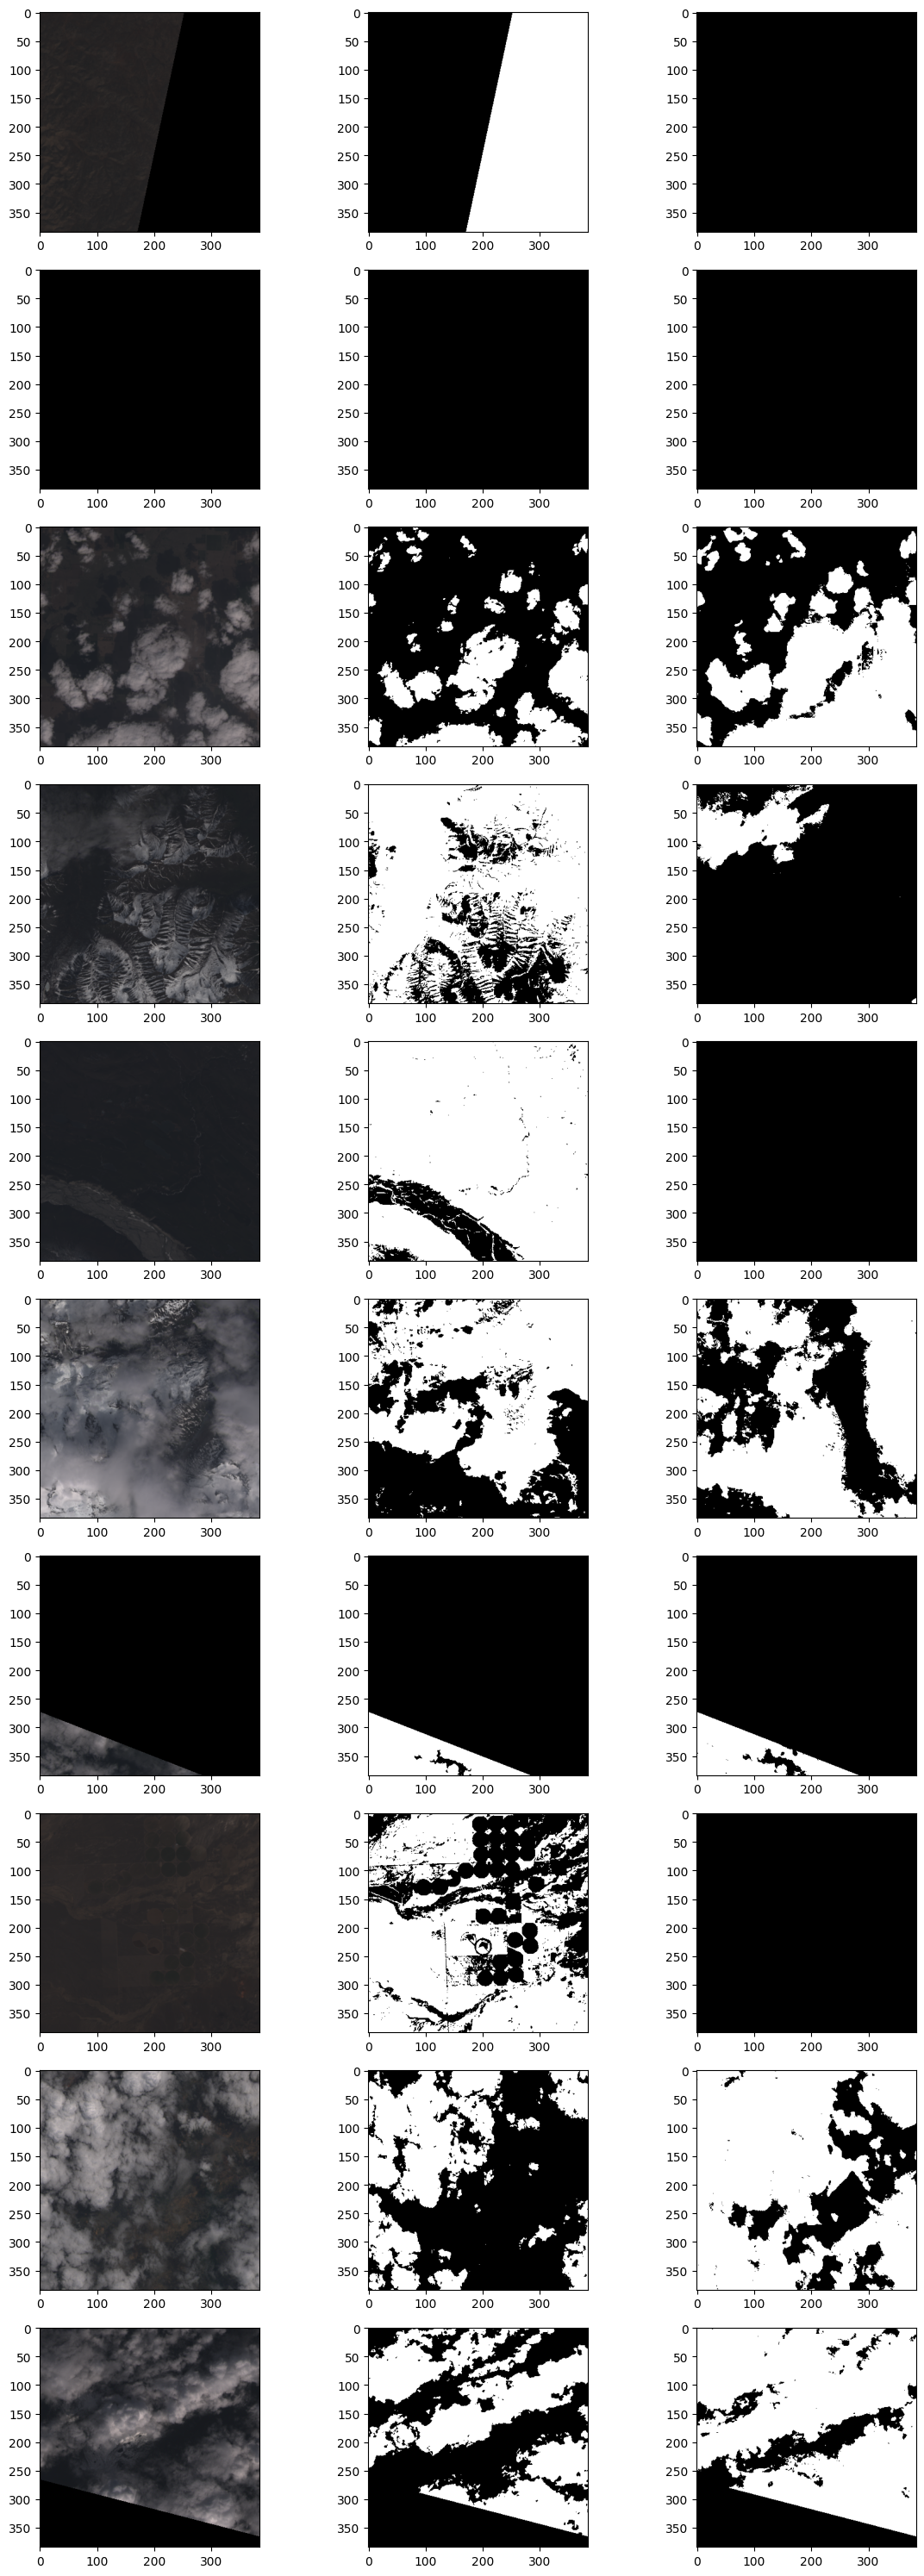

In [ ]:
visualize_kmeans_segmentation(test_dataset, num_samples=10)

## **K-Means con NDVI, NDWI e NIR/Red ratio + centroidi guidati**

In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Nasconde warning di K-Means


In [ ]:
def extract_features(img):
    """
    Estrae feature significative per il clustering, basandosi sulle bande spettrali.
    Include:
    - Red, Green, Blue, NIR
    - NDVI (indice di vegetazione)
    - NDWI (indice di acqua, usato per la neve)
    - Rapporto NIR/Red per distinguere le nuvole
    """
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    NIR = img[:, :, 3]

    # Calcoliamo gli indici
    NDVI = (NIR - R) / (NIR + R + 1e-6)  # Normalized Difference Vegetation Index
    NDWI = (G - NIR) / (G + NIR + 1e-6)  # Normalized Difference Water Index
    NIR_Ratio = NIR / (R + 1e-6)  # Rapporto tra NIR e Red

    # Stackiamo le feature per usarle nel clustering
    features = np.stack([R, G, B, NIR, NDVI, NDWI, NIR_Ratio], axis=-1)
    return features


In [ ]:
def apply_kmeans_guided(img, k=2):
    """
    Applica K-Means clustering con inizializzazione guidata.
    - Usa centroidi iniziali specifici per forzare la segmentazione più corretta.
    """
    H, W, C = img.shape
    features = extract_features(img)  # Estraggo le feature avanzate
    features_reshaped = features.reshape(-1, features.shape[-1])  # (H*W, num_features)


    if np.all(features_reshaped == features_reshaped[0]):
        return np.zeros((H, W), dtype=np.uint8)

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_reshaped)

    #  centroidi iniziali basati su indici comuni nelle nuvole
    cloud_reference = np.array([0.3, 0.3, 0.3, 0.8, -0.1, -0.5, 3.0])
    non_cloud_reference = np.array([0.6, 0.6, 0.6, 0.3, 0.5, 0.3, 0.5])

    # Normalizziamo i centroidi nello stesso range delle feature
    cloud_reference = scaler.transform([cloud_reference])[0]
    non_cloud_reference = scaler.transform([non_cloud_reference])[0]

    # Usiamo questi valori come centroidi iniziali
    init_centroids = np.stack([cloud_reference, non_cloud_reference])

    # Applichiamo K-Means con centroidi iniziali fissi
    kmeans = KMeans(n_clusters=k, init=init_centroids, n_init=1, random_state=42)
    kmeans.fit(features_scaled)
    labels = kmeans.labels_

    # Ricostruiamo l'immagine segmentata
    clustered_img = labels.reshape(H, W)
    return clustered_img


In [ ]:
def align_clusters(pred_mask, true_mask, img):
    """
    Corregge i cluster basandosi sulla sovrapposizione con la ground truth,
    escludendo i pixel neri dalle immagini tagliate.
    """
    # Identifichiamo i pixel neri (zone senza dati)
    black_pixels = np.all(img == 0, axis=-1)

    # Consideriamo solo i pixel validi (non neri)
    valid_pixels = ~black_pixels

    # Se tutti i pixel sono neri, non facciamo nulla
    if np.sum(valid_pixels) == 0:
        return pred_mask  # Non c'è nulla da correggere

    # Filtriamo solo i pixel validi per il confronto
    pred_mask_valid = pred_mask[valid_pixels]
    true_mask_valid = true_mask[valid_pixels]

    # Contiamo quanti pixel di ogni cluster corrispondono a nuvole
    intersection_0 = np.logical_and(pred_mask_valid == 0, true_mask_valid == 1).sum()
    intersection_1 = np.logical_and(pred_mask_valid == 1, true_mask_valid == 1).sum()

    # Se il cluster 1 corrisponde più spesso alle nuvole, lasciamo così
    if intersection_1 > intersection_0:
        return pred_mask  # Già corretto
    else:
        return 1 - pred_mask  # Invertiamo le etichette


In [ ]:
def apply_kmeans_with_correction(img, true_mask, k=2):
    """
    Applica K-Means all'immagine e corregge l'ordine dei cluster usando il nuovo metodo.
    """
    clustered_img = apply_kmeans_guided(img, k)  # Applichiamo K-Means
    corrected_img = align_clusters(clustered_img, true_mask, img)  # Correggiamo i cluster
    return corrected_img


In [ ]:
def intersection_over_union(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        intersection = torch.logical_and(pred, target).sum().float()
        union = torch.logical_or(pred, target).sum().float()
        return intersection / (union + 1e-9)

def dice_coefficient(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        intersection = torch.sum(pred * target).float()
        fsum = torch.sum(pred).float()
        ssum = torch.sum(target).float()
        return (2 * intersection) / (fsum + ssum + 1e-9)

def precision_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fp = torch.logical_and(pred, 1 - target).sum().float()
        return tp / (tp + fp + 1e-9)

def recall_score(pred, target):
    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    elif torch.sum(target) == 0 and torch.sum(pred) > 0:
        return 0.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        fn = torch.logical_and(1 - pred, target).sum().float()
        return tp / (tp + fn + 1e-9)

def accuracy_score(pred, target):
    pred = pred.bool()
    target = target.bool()

    if torch.sum(target) == 0 and torch.sum(pred) == 0:
        return 1.0
    else:
        tp = torch.logical_and(pred, target).sum().float()
        tn = torch.logical_and(~pred, ~target).sum().float()
        fp = torch.logical_and(pred, ~target).sum().float()
        fn = torch.logical_and(~pred, target).sum().float()
        return (tp + tn) / (tp + tn + fp + fn + 1e-9)


In [ ]:
def evaluate_kmeans_guided(test_loader, k=2):
    """
    Applica K-Means guidato con centroidi iniziali, corregge automaticamente i cluster
    e calcola le metriche sul test set.
    """
    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    test_iterator = tqdm(test_loader, desc="[TESTING GUIDED K-MEANS]", leave=True)

    for images, masks in test_iterator:
        images, masks = images.numpy(), masks.numpy()

        for i in range(len(images)):  # Iteriamo sulle immagini nel batch
            img = images[i].transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
            mask = masks[i]

            # Applichiamo K-Means e correggiamo i cluster PRIMA di calcolare le metriche
            clustered_img = apply_kmeans_with_correction(img, mask, k)

            clustered_tensor = torch.tensor(clustered_img)
            mask_tensor = torch.tensor(mask)

            IoU = intersection_over_union(clustered_tensor, mask_tensor)
            Dice = dice_coefficient(clustered_tensor, mask_tensor)
            Precision = precision_score(clustered_tensor, mask_tensor)
            Recall = recall_score(clustered_tensor, mask_tensor)
            Accuracy = accuracy_score(clustered_tensor, mask_tensor)

            iou_scores.append(IoU)
            dice_scores.append(Dice)
            precision_scores.append(Precision)
            recall_scores.append(Recall)
            accuracy_scores.append(Accuracy)

    avg_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice": np.mean(dice_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "Accuracy": np.mean(accuracy_scores),
    }

    print("\n✅ K-Means Guided Evaluation Completed! (CORRETTO)")
    return avg_metrics


In [ ]:
kmeans_guided_metrics = evaluate_kmeans_guided(test_loader, k=2)

[TESTING GUIDED K-MEANS]: 100%|██████████| 105/105 [01:18<00:00,  1.34it/s]


✅ K-Means Guided Evaluation Completed! (CORRETTO)


In [ ]:
def print_kmeans_metrics(metrics_dict):
    """
    Stampa le metriche di K-Means in modo chiaro e leggibile.
    """
    print("\n📊 **K-Means Advanced Clustering Results** 📊")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")

# Dopo aver eseguito la valutazione, stampiamo i risultati
print_kmeans_metrics(kmeans_guided_metrics)



📊 **K-Means Advanced Clustering Results** 📊
IoU: 0.6795
Dice: 0.7453
Precision: 0.8023
Recall: 0.7785
Accuracy: 0.7948


In [ ]:
def visualize_kmeans_guided(dataset, num_samples=3):
    """
    Displays the original RGB image (enhanced for visualization only) while using original values for K-means.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)  # Convert tensor to image
        mask = mask.numpy()

        # Use original image for K-means
        clustered_img = apply_kmeans_with_correction(img, mask, k=2)

        # Get RGB channels for visualization
        rgb_img = img[:, :, :3].copy()  # Make a copy for visualization

        # Enhanced contrast normalization for display only (per channel)
        rgb_enhanced = np.zeros_like(rgb_img)
        for c in range(3):
            channel = rgb_img[:, :, c]
            if channel.max() > channel.min():  # Avoid division by zero
                # Contrast stretching per channel
                p2, p98 = np.percentile(channel, (2, 98))
                rgb_enhanced[:, :, c] = np.clip(exposure.rescale_intensity(channel, in_range=(p2, p98)), 0, 1)
            else:
                rgb_enhanced[:, :, c] = channel

        # Display the enhanced image (but K-means used original)
        axs[i, 0].imshow(rgb_enhanced)
        axs[i, 0].set_title("Original Image")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(clustered_img, cmap="gray")
        axs[i, 1].set_title("Guided K-Means Segmentation")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(mask, cmap="gray")
        axs[i, 2].set_title("Ground Truth")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

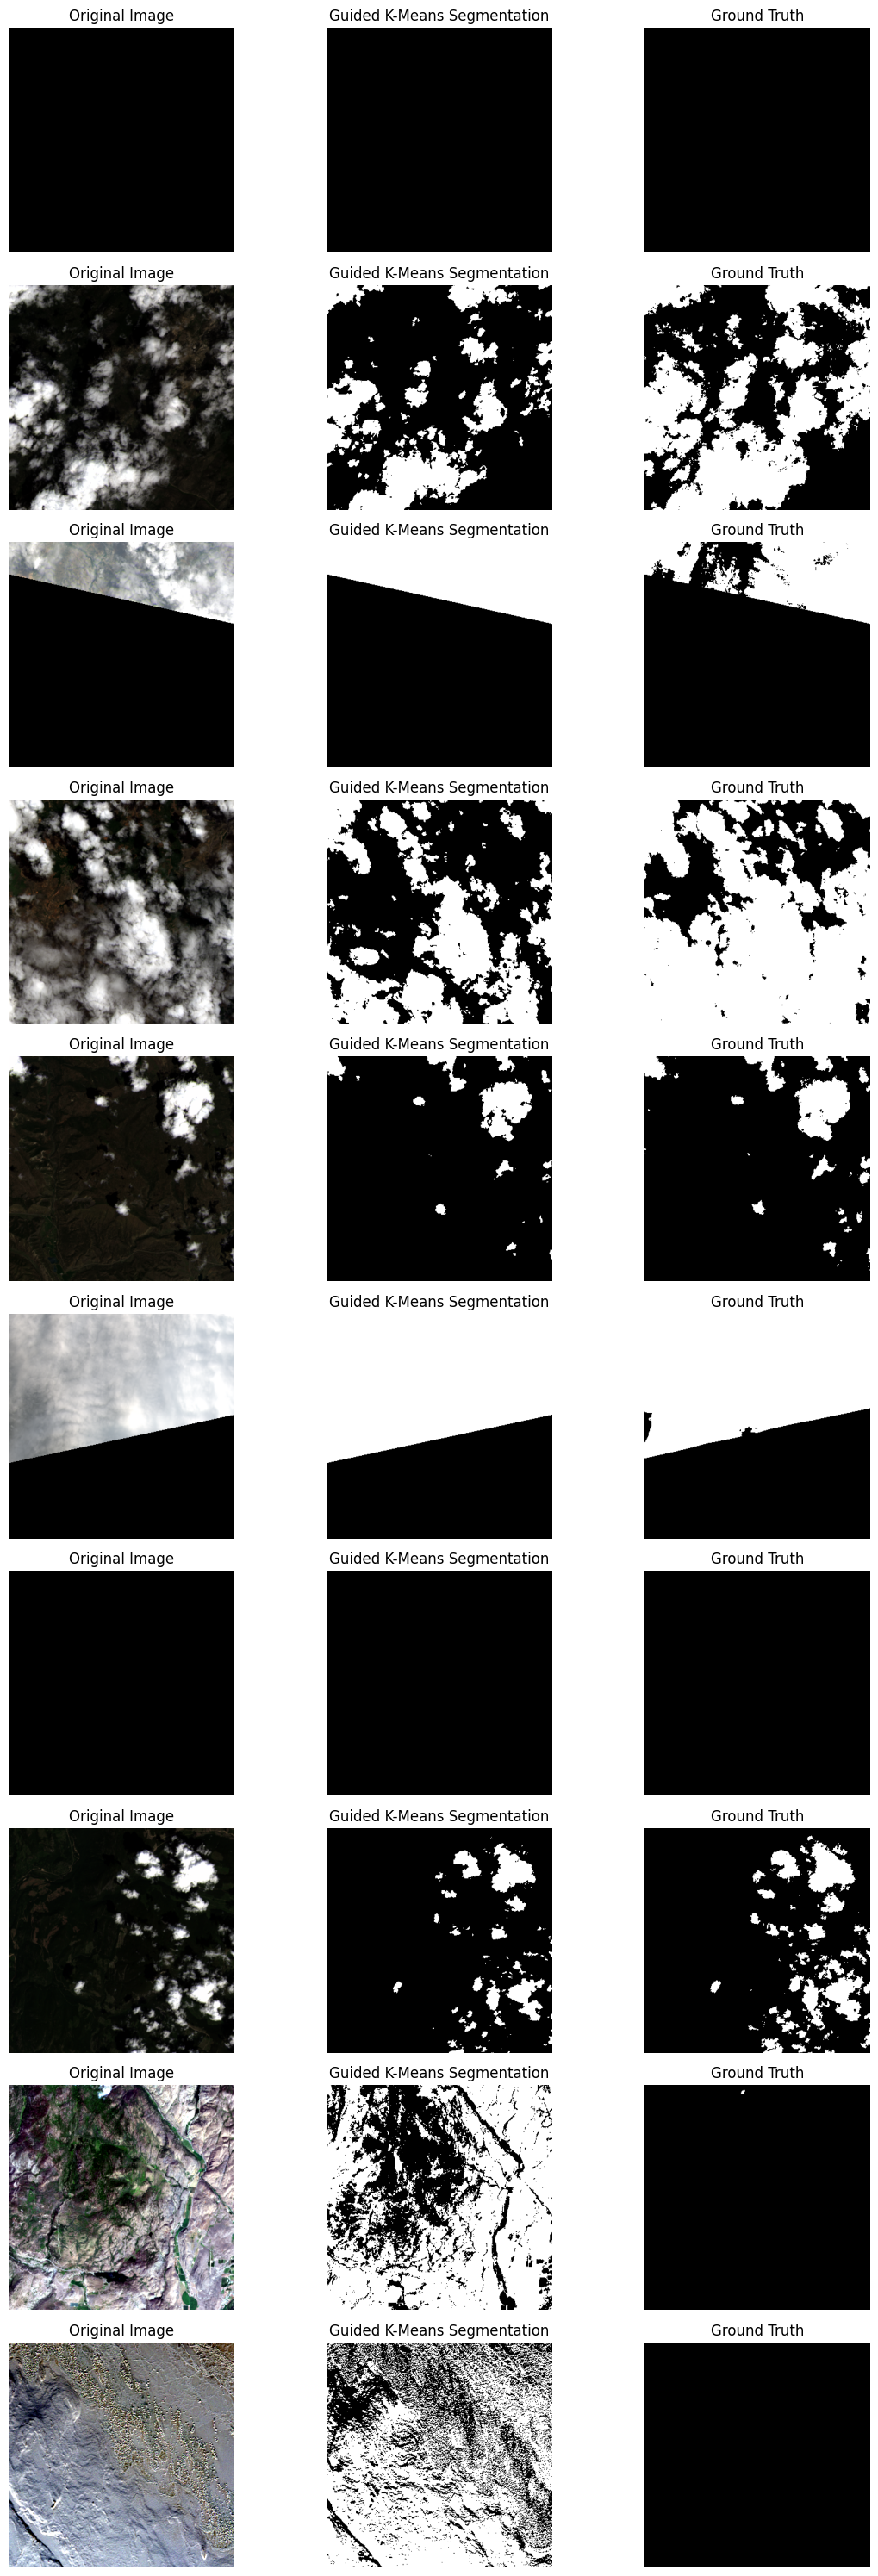

In [ ]:
visualize_kmeans_guided(test_dataset, num_samples=10)

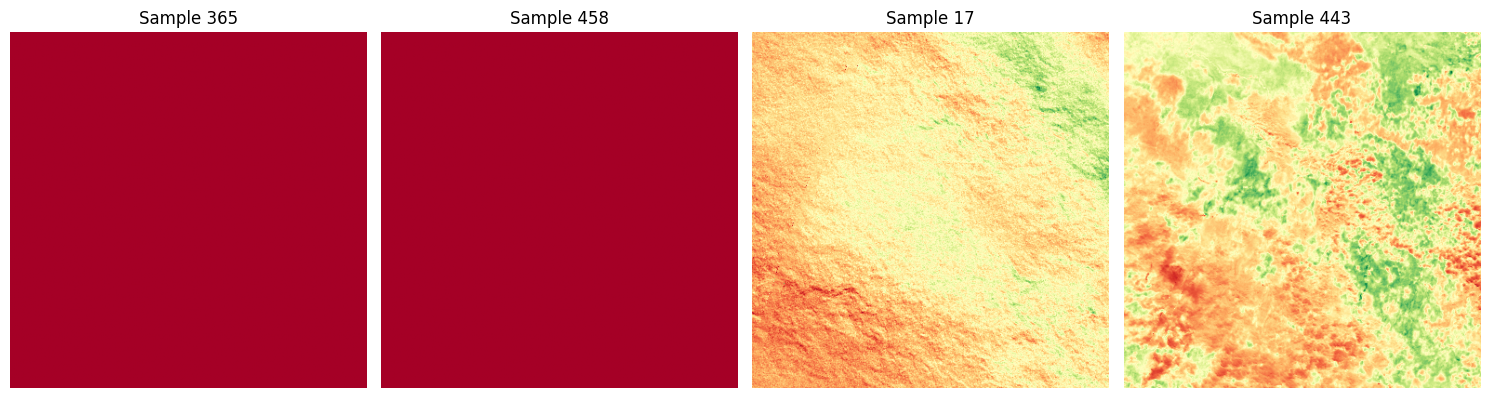

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_ndvi_samples(dataset, num_samples=4):
    """
    Displays NDVI feature maps for randomly selected images from the dataset.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)


        R = img[:, :, 0]
        NIR = img[:, :, 3]
        NDVI = (NIR - R) / (NIR + R + 1e-6)

        axs[i].imshow(NDVI, cmap="RdYlGn")
        axs[i].set_title(f"Sample {idx}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


visualize_ndvi_samples(test_dataset, num_samples=4)


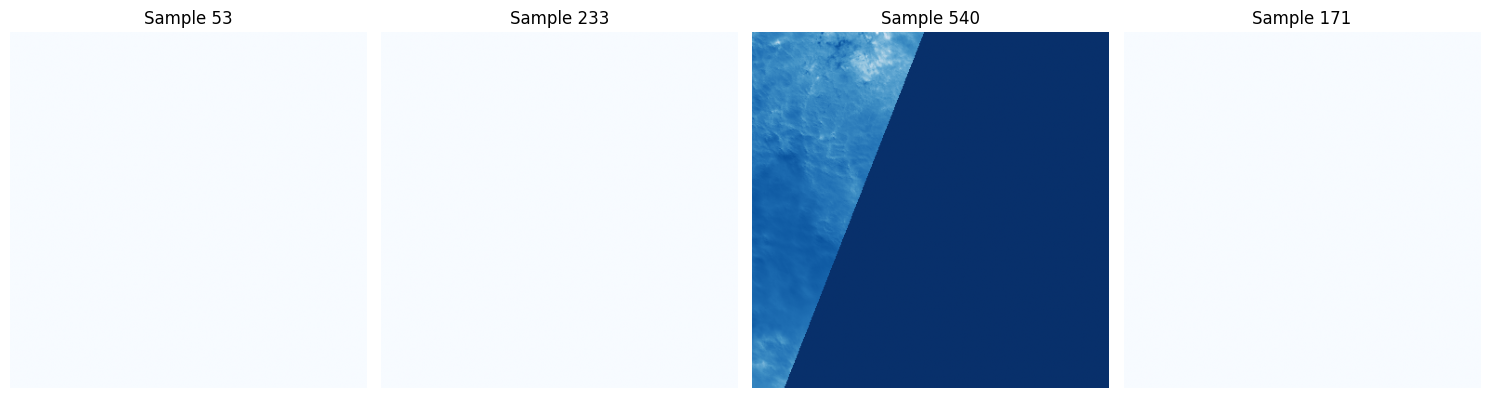

In [ ]:


def visualize_ndwi_samples(dataset, num_samples=4):

    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]  # Extract image (ignore mask)
        img = img.numpy().transpose(1, 2, 0)

        G = img[:, :, 1]
        NIR = img[:, :, 3]
        NDWI = (G - NIR) / (G + NIR + 1e-6)

        axs[i].imshow(NDWI, cmap="Blues")
        axs[i].set_title(f"Sample {idx}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


visualize_ndwi_samples(test_dataset, num_samples=4)
